In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model, load_model

from google.colab import drive
drive.mount('/content/drive')

#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/new/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

# Define paths to training and testing data
train_path = '/tmp/chest_xray/train/'
test_path = '/tmp/chest_xray/test'

# Define image size and batch size
img_size = (299, 299)
batch_size = 32

# Define pre-trained InceptionV3 model
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add new output layers to the pre-trained model
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Define data generators for training and testing
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='binary')

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Save the trained model
model.save('pneumonia_detection_model.h5')


Mounted at /content/drive
87910968/87910968 [==============================] - 1s 0us/step
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/50
163/163 [==============================] - 102s 517ms/step - loss: 0.3763 - accuracy: 0.8608 - val_loss: 0.6091 - val_accuracy: 0.7788
Epoch 2/50
163/163 [==============================] - 83s 508ms/step - loss: 0.1898 - accuracy: 0.9231 - val_loss: 0.5896 - val_accuracy: 0.7949
Epoch 3/50
163/163 [==============================] - 82s 505ms/step - loss: 0.1552 - accuracy: 0.9388 - val_loss: 0.3293 - val_accuracy: 0.8798
Epoch 4/50
163/163 [==============================] - 83s 507ms/step - loss: 0.1323 - accuracy: 0.9457 - val_loss: 0.6508 - val_accuracy: 0.8029
Epoch 5/50
163/163 [==============================] - 81s 499ms/step - loss: 0.1265 - accuracy: 0.9542 - val_loss: 0.5396 - val_accuracy: 0.8317
Epoch 6/50
163/163 [==============================] - 81s 498ms/step - loss: 0.1241 - accuracy: 0.95

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model, load_model
img_size = (299, 299)
batch_size = 32

In [ ]:
# Load the trained model
model = load_model('pneumonia_detection_model.h5')

# Define path to test images
test_path = '/tmp/chest_xray/test'

# Create a data generator for testing
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test images
predictions = model.predict(test_generator)

# Convert predictions to binary labels (0 or 1)
predicted_labels = np.round(predictions)

# Get true labels for the test images
true_labels = test_generator.classes

# Calculate accuracy and other metrics
accuracy = np.mean(predicted_labels == true_labels)
precision = np.sum((predicted_labels == 1) & (true_labels == 1)) / np.sum(predicted_labels == 1)
recall = np.sum((predicted_labels == 1) & (true_labels == 1)) / np.sum(true_labels == 1)
f1_score = 2 * precision * recall / (precision + recall)

# Print metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)


Found 624 images belonging to 2 classes.
20/20 [==============================] - 10s 389ms/step
Accuracy: 0.5897435897435898
Precision: 390.0
Recall: 536.0
F1 Score: 451.4902807775378


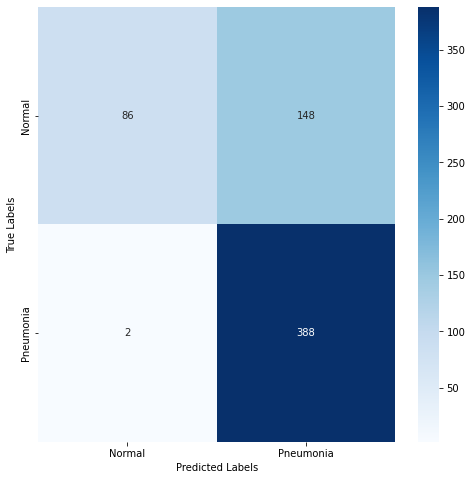

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels for the test images
true_labels = test_generator.classes

# Convert predictions to binary labels (0 or 1)
predicted_labels = np.round(predictions)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


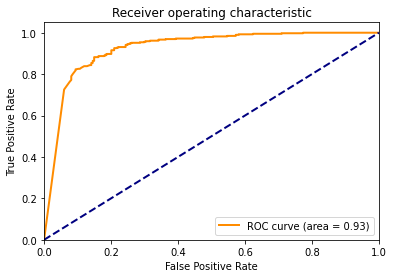

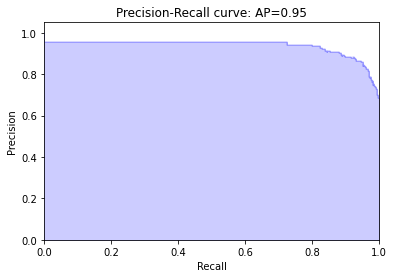

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Compute precision-recall curve and average precision for each class
precision, recall, _ = precision_recall_curve(true_labels, predictions)
avg_precision = auc(recall, precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(avg_precision))
plt.show()
